# Модель для прогнозирования оттока клиентов для сервиса доставки кофе

# План работы

## Этап 1. Подготовка среды и библиотек
1. Установите и настройте библиотеки. Для воспроизводимости результатов зафиксируйте версии пакетов в файле `requirements.txt`.

2. Зафиксируйте `random_state`.

3. Загрузите данные из CSV-файла. Путь к файлу: `'/datasets/coffee_churn_dataset.csv'`. Используйте сепаратор `","`, а для чтения чисел с плавающей точкой — параметр `decimal="."`.

In [1]:
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn, matplotlib

print(
    "pandas:", pd.__version__,
    "| numpy:", np.__version__,
    "| sklearn:", sklearn.__version__,
    "| matplotlib:", matplotlib.__version__,
    "| seaborn:", sns.__version__,
    "| joblib:", joblib.__version__
)

pandas: 1.2.4 | numpy: 1.21.1 | sklearn: 0.24.1 | matplotlib: 3.3.4 | seaborn: 0.11.1 | joblib: 1.1.0


In [2]:
requirements = """
pandas==1.2.4
numpy==1.21.1
scikit-learn==0.24.1
matplotlib==3.3.4
seaborn==0.11.1
joblib==1.1.0
"""

with open("requirements.txt", "w") as f:
    f.write(requirements)

Для воспроизводимости результатов зафиксированы версии используемых библиотек в файле requirements.txt.

In [3]:
RANDOM_STATE = 42

Для обеспечения воспроизводимости экспериментов зафиксирован параметр random_state.

In [4]:
df = pd.read_csv(
    '/datasets/coffee_churn_dataset.csv',
    sep=',',
    decimal='.'
)

df.head()

,user_id,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,...,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,geo_location,churn
0,user_00318,0.0,12.942519,NaN,316.833872,260.645090,3089.991009,NaN,0.337031,blend,...,1.0,5.176792,3.302238,NaN,summer,6.0,android,0.0,geo_75,1
1,user_07234,2.0,1.569146,0.214494,780.135158,540.597850,998.380941,107.369409,0.547659,arabica,...,1.0,4.392991,NaN,0.0,autumn,16.0,ios,0.0,geo_95,0
2,user_04816,11.0,2.996666,0.771864,682.636256,471.494559,1328.140204,392.600011,0.120258,arabica,...,1.0,4.977712,4.379219,0.0,spring,11.0,web,1.0,geo_25,0
3,user_04419,0.0,4.299255,1.210480,2115.487425,708.529812,2999.628366,1084.352054,NaN,robusta,...,1.0,3.712526,3.043618,0.0,summer,3.0,android,0.0,geo_2,0
4,user_09698,3.0,7.249864,1.761027,3519.602170,1199.372894,8377.729478,2551.775211,0.074990,robusta,...,0.0,4.528271,5.642993,1.0,winter,14.0,ios,0.0,geo_19,1


In [5]:
df.shape

(10450, 27)

Данные успешно загружены.<br>
Датасет содержит 10450 наблюдений и 27 признаков.<br>
В выборке присутствуют числовые и категориальные признаки, а также целевая переменная churn, отражающая факт оттока клиента.<br>

## Этап 2. Первичный анализ данных

1. Опишите данные. Кратко сообщите, что известно о пользователях и их поведении.

2. Опишите целевую переменную. Обратите внимание на возможные особенности её распределения. Проверьте, наблюдается ли дисбаланс классов в целевой переменной.

3. Опишите признаки.

   - Определите, все ли из них важны.

   - Объясните, какие из них можно удалить (если такие есть). Аргументируйте своё решение.

4. Обработайте пропущенные значения.
   
   - Объясните, как они влияют на данные.

   - Выберите стратегию заполнения пропусков.

5. Проанализируйте категориальные признаки.

   - Выясните, есть ли в данных признаки, которые можно кодировать. Объясните, почему именно их нужно кодировать.

   - Проанализируйте признаки на предмет того, можно ли использовать некоторые из них для генерации новых  признаков. Укажите возможные стратегии.

   - Определите, есть ли в данных признаки, которые можно удалить.

6. Проанализируйте выбросы.

   - Определите, как они влияют на данные.

   - Выберите способ, которым их можно обработать.

7. Посчитайте корреляции между признаками. Постройте необходимые визуализации. Определите, есть ли признаки, которые можно убрать, на основании их корреляции с другими.

8. Напишите выводы по результатам исследовательского анализа данных.

In [6]:
df['churn'].value_counts()

0    9821
1     629
Name: churn, dtype: int64

In [7]:
df['churn'].value_counts(normalize=True)

0    0.939809
1    0.060191
Name: churn, dtype: float64

Целевая переменная churn отражает факт ухода клиента.<br>
В выборке наблюдается выраженный дисбаланс классов: доля ушедших клиентов составляет около 6%.<br>

В связи с сильным дисбалансом использование метрики Accuracy некорректно, так как модель может демонстрировать высокую точность, просто предсказывая большинство класса.<br>

В качестве основной метрики выбрана PR-AUC, поскольку она лучше отражает качество модели при работе с редким положительным классом.<br>

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10450 non-null  object 
 1   days_since_last_order     9505 non-null   float64
 2   order_frequency_month     9850 non-null   float64
 3   order_frequency_week      10062 non-null  float64
 4   avg_order_value           9867 non-null   float64
 5   median_order_value        9619 non-null   float64
 6   total_spent_last_month    10156 non-null  float64
 7   total_spent_last_week     9506 non-null   float64
 8   discount_usage_rate       10053 non-null  float64
 9   last_coffee_type          10192 non-null  object 
 10  preferred_roast           10334 non-null  object 
 11  milk_preference           9782 non-null   object 
 12  seasonal_menu_tried       9461 non-null   float64
 13  coffee_bean_origin        9768 non-null   object 
 14  last_d

Признак user_id является уникальным идентификатором пользователя и не несёт прогностической ценности.<br>
Он будет удалён перед обучением модели, чтобы избежать утечки информации и переобучения.

In [9]:
df = df.drop(columns=['user_id'])

In [10]:
missing = df.isna().mean().sort_values(ascending=False)
missing

seasonal_menu_tried         0.094641
days_since_last_order       0.090431
total_spent_last_week       0.090335
subscription_status         0.089761
app_opens_per_week          0.085742
review_rating_last_1        0.082010
median_order_value          0.079522
days_since_last_promo       0.069952
app_crashes_last_month      0.068995
review_rating_last_10       0.066316
coffee_bean_origin          0.065263
seasons                     0.064976
milk_preference             0.063923
coffee_preference_change    0.058373
order_frequency_month       0.057416
avg_order_value             0.055789
notifications_enabled       0.051388
last_drink_size             0.048230
discount_usage_rate         0.037990
order_frequency_week        0.037129
phone_type                  0.032153
total_spent_last_month      0.028134
last_coffee_type            0.024689
preferred_roast             0.011100
geo_location                0.010526
churn                       0.000000
dtype: float64

В данных присутствуют пропуски почти во всех признаках, но их доля относительно небольшая (в основном до 10%).<br>
Удаление строк с пропусками приведёт к потере значимой части данных, поэтому пропуски будут обрабатываться с помощью импутации.

Для числовых признаков будет использована замена на медиану (устойчива к выбросам), для категориальных замена на наиболее частое значение.<br>
Импутация будет выполнена внутри Pipeline, чтобы избежать утечки данных при кросс-валидации.

In [11]:
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['last_coffee_type', 'preferred_roast', 'milk_preference',
       'coffee_bean_origin', 'last_drink_size', 'subscription_status',
       'seasons', 'phone_type', 'geo_location'],
      dtype='object')

In [12]:
df[cat_cols].nunique().sort_values(ascending=False)

geo_location           100
milk_preference          6
coffee_bean_origin       6
subscription_status      4
seasons                  4
last_coffee_type         3
preferred_roast          3
last_drink_size          3
phone_type               3
dtype: int64

Все категориальные признаки будут закодированы с помощью One-Hot Encoding.<br>
Признак geo_location содержит 100 уникальных значений, однако размер датасета позволяет использовать его без удаления.

Для предотвращения ошибок при появлении новых категорий будет использован параметр handle_unknown='ignore'.

In [13]:
bin_cols = ['seasonal_menu_tried', 'notifications_enabled', 'coffee_preference_change']

for col in bin_cols:
    print(col, df[col].unique())

seasonal_menu_tried [nan  1.  0.]
notifications_enabled [ 1.  0. nan]
coffee_preference_change [ 0.  1. nan]


Признаки seasonal_menu_tried, notifications_enabled и coffee_preference_change являются бинарными (0/1).<br>
Пропущенные значения в них будут заполнены наиболее частым значением.<br>
Дополнительного кодирования для них не требуется.<br>

In [14]:
num_cols = df.select_dtypes(include=['float64']).columns
num_cols

Index(['days_since_last_order', 'order_frequency_month',
       'order_frequency_week', 'avg_order_value', 'median_order_value',
       'total_spent_last_month', 'total_spent_last_week',
       'discount_usage_rate', 'seasonal_menu_tried', 'app_opens_per_week',
       'notifications_enabled', 'review_rating_last_10',
       'review_rating_last_1', 'app_crashes_last_month',
       'days_since_last_promo', 'coffee_preference_change'],
      dtype='object')

В датасете присутствуют 16 числовых признаков, отражающих поведение пользователей: частоту заказов, средний чек, расходы, активность в приложении, использование скидок и другие характеристики.

Числовые признаки будут:

- заполнены медианой (для устойчивости к выбросам)

- стандартизированы перед обучением модели.

In [15]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
days_since_last_order,9505.0,4.394214,4.858757,0.000000,1.000000,3.000000,6.000000,40.000000
order_frequency_month,9850.0,4.025666,2.826144,0.011046,1.937767,3.381094,5.439363,27.389318
order_frequency_week,10062.0,0.930686,0.657261,-0.169131,0.445185,0.784839,1.262350,6.302624
avg_order_value,9867.0,1063.741207,707.713396,-32.075932,552.898663,898.643524,1406.332153,5901.965278
median_order_value,9619.0,452.651500,258.657571,-10.353340,262.908598,406.456818,590.418070,2189.101644
total_spent_last_month,10156.0,1946.132979,2370.619590,-43.716463,629.680382,1300.409757,2481.650495,79298.849570
total_spent_last_week,9506.0,413.004760,445.634902,-2290.559468,136.565833,288.277327,549.699420,8615.988952
discount_usage_rate,10053.0,0.284446,0.158735,0.002162,0.159884,0.264583,0.387056,0.887301
seasonal_menu_tried,9461.0,0.701194,0.457759,0.000000,0.000000,1.000000,1.000000,1.000000
app_opens_per_week,9554.0,11.330895,14.528887,0.000000,6.313628,9.228383,12.726649,224.587876


В числовых признаках обнаружены выбросы и аномальные значения.<br>
В частности, в ряде финансовых признаков присутствуют отрицательные значения, что экономически невозможно и может быть связано с особенностями генерации данных.

Также наблюдаются сильные правые хвосты распределений (например, total_spent_last_month, app_opens_per_week).

Поскольку доля таких значений невелика, удаление наблюдений может привести к потере информации.<br>
Для минимизации влияния выбросов будет использована медианная импутация и стандартизация признаков в рамках Pipeline.

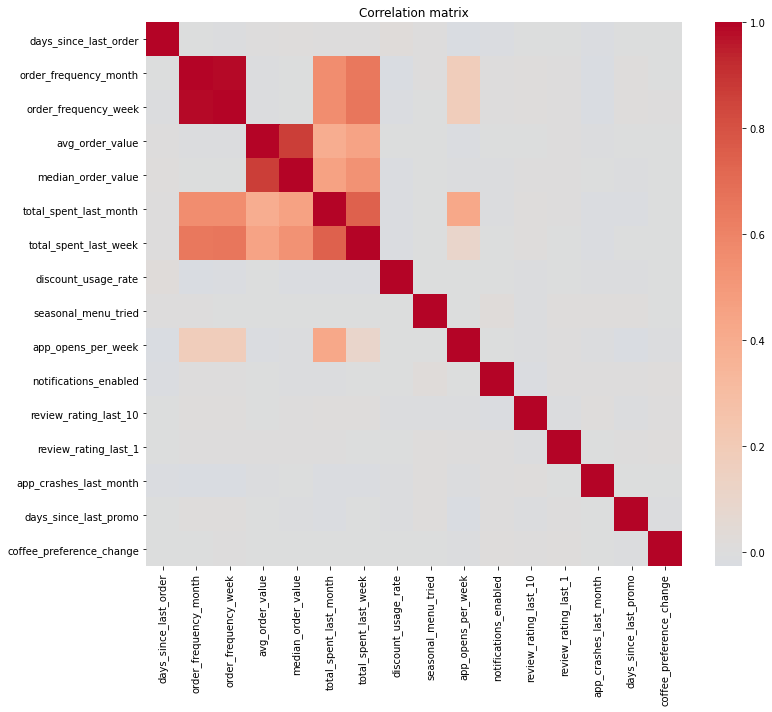

In [16]:
plt.figure(figsize=(12, 10))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0)
plt.title("Correlation matrix")
plt.show()

In [17]:
corr_matrix = df[num_cols].corr().abs()

upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr = (
    upper_triangle
    .stack()
    .sort_values(ascending=False)
)

high_corr[high_corr > 0.7]

order_frequency_month   order_frequency_week     0.988474
avg_order_value         median_order_value       0.868503
total_spent_last_month  total_spent_last_week    0.745806
dtype: float64

При анализе корреляций выявлена крайне высокая зависимость (0.99) между признаками order_frequency_month и order_frequency_week, что свидетельствует о практически линейной связи между ними.

Для снижения мультиколлинеарности и повышения интерпретируемости модели признак order_frequency_week был удалён.

Остальные признаки демонстрируют умеренную корреляцию, которая не является критичной при использовании регуляризованной логистической регрессии.

In [18]:
df = df.drop(columns=['order_frequency_week'])

Признаки avg_order_value и median_order_value демонстрируют высокую корреляцию (0.87), однако они отражают разные аспекты распределения расходов клиента.<br>
Среднее чувствительно к выбросам, тогда как медиана более устойчива.<br>
В связи с этим оба признака сохраняются в модели.

В ходе анализа данных выявлен выраженный дисбаланс классов (доля оттока около 6%), что обосновывает использование метрики PR-AUC.<br>
В данных присутствуют пропуски и выбросы, поэтому выбрана стратегия медианной импутации и стандартизации признаков в рамках Pipeline.<br>
Признак user_id удалён как неинформативный идентификатор.<br>
Также удалён признак order_frequency_week из-за высокой корреляции с order_frequency_month.<br>
Данные подготовлены к построению модели.

## Этап 3. Предобработка данных

1. Разделите данные в пропорции 80 к 20. 20% данных отложите для теста. Остальные используйте для обучения и кросс-валидации модели.

2. Предобработайте данные. Используйте информацию о пропусках и категориальных признаках только из обучающей выборки.

   - Создайте пайплайн, который обработает пропуски и выбросы.

   - Создайте пайплайн, который обработает категориальные признаки.

   - Создайте пайплайн, который обработает числовые признаки: проведёт масштабирование и нормализацию.



In [19]:
X = df.drop(columns=['churn'])
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (8360, 24)
Test shape: (2090, 24)


Данные разделены в пропорции 80/20 с использованием стратификации по целевой переменной для сохранения распределения классов.<br>
Тестовая выборка отложена и не будет использоваться при обучении и кросс-валидации.

In [20]:
num_cols = X_train.select_dtypes(include=['float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("Numerical:", len(num_cols))
print("Categorical:", len(cat_cols))

Numerical: 15
Categorical: 9


Типы признаков определены на обучающей выборке, чтобы избежать утечки данных.<br>
Выделено 15 числовых и 9 категориальных признаков.

In [21]:
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [22]:
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [23]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

Предобработка реализована через Pipeline и ColumnTransformer, чтобы все трансформации выполнялись только на обучающих данных внутри кросс-валидации и не возникало утечки данных.

Для числовых признаков используется медианная импутация и стандартизация (StandardScaler), что снижает влияние выбросов и приводит признаки к сопоставимому масштабу.
Для категориальных признаков используется заполнение наиболее частым значением и One-Hot Encoding с handle_unknown='ignore'.

## Этап 4. Обучение модели

1. Обучите базовую версию модели.
   - Используйте для этого простые статистические модели.

   - Используйте кросс-валидацию для обучения модели.

2. Посчитайте метрики, поставленные в задаче. Опираясь на них, сделайте вывод о качестве модели.

In [24]:
baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

baseline_cv = cross_validate(
    baseline_model,
    X_train,
    y_train,
    cv=cv,
    scoring="average_precision",
    n_jobs=-1,
    return_train_score=False
)

print("Baseline PR-AUC (mean):", baseline_cv["test_score"].mean())
print("Baseline PR-AUC (std):", baseline_cv["test_score"].std())
print("Scores:", baseline_cv["test_score"])

Baseline PR-AUC (mean): 0.060167464114832536
Baseline PR-AUC (std): 0.00029300116540468787
Scores: [0.05980861 0.05980861 0.0604067  0.0604067  0.0604067 ]


Базовая модель (DummyClassifier, стратегия most_frequent) показала PR-AUC 0.06.<br>
Это значение совпадает с долей положительного класса в данных 6%, что соответствует ожидаемому уровню случайного классификатора при использовании PR-AUC.

Таким образом, полученный результат служит нижней границей качества.
Для практического применения модель должна демонстрировать PR-AUC существенно выше этого уровня.

In [25]:
logreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000
    ))
])

logreg_cv = cross_validate(
    logreg_model,
    X_train,
    y_train,
    cv=cv,
    scoring="average_precision",
    n_jobs=-1,
    return_train_score=False
)

print("LogReg PR-AUC (mean):", logreg_cv["test_score"].mean())
print("LogReg PR-AUC (std):", logreg_cv["test_score"].std())
print("Scores:", logreg_cv["test_score"])

LogReg PR-AUC (mean): 0.6564008071821893
LogReg PR-AUC (std): 0.051755994171672606
Scores: [0.59903211 0.63889022 0.63990605 0.75380312 0.65037254]


Логистическая регрессия показала среднее значение PR-AUC 0.656 по результатам 5-кратной стратифицированной кросс-валидации.

Это существенно превышает baseline (0.06), что свидетельствует о способности модели выявлять уходящих клиентов.<br>
Разброс метрики между фолдами умеренный (std = 0.05), что указывает на стабильность модели.

## Этап 5. Создание новых признаков

1. Добавьте новые признаки, которые могут улучшить качество модели. Опирайтесь на наработки, полученные в ходе исследовательского анализа данных, и на логику решаемой задачи.

   - Извлечение квадратного корня поможет сгладить большие значения.

   - Возведение в квадрат усилит влияние больших значений.

2. Обновите пайплайн для работы с новыми признаками, проведите повторную кросс-валидацию, сравните результаты моделей с новыми признаками и без них.

3. Интерпретируйте коэффициенты модели, а затем на их основании выявите значимые признаки и удалите лишние для модели.

In [26]:
def add_features(X):
    X = X.copy()

    def safe_log1p(s):
        return np.log1p(np.clip(s, 0, None))

    def safe_sqrt(s):
        return np.sqrt(np.clip(s, 0, None))

    if "total_spent_last_week" in X.columns:
        X["log_total_spent_last_week"] = safe_log1p(X["total_spent_last_week"])

    if "avg_order_value" in X.columns:
        X["log_avg_order_value"] = safe_log1p(X["avg_order_value"])

    if "order_frequency_month" in X.columns:
        X["order_frequency_month_sq"] = X["order_frequency_month"] ** 2

    if "app_opens_per_week" in X.columns:
        X["sqrt_app_opens_per_week"] = safe_sqrt(X["app_opens_per_week"])

    return X

feature_engineering = FunctionTransformer(add_features)

In [27]:
X_tmp = add_features(X_train)

print("shape:", X_tmp.shape)
print("NaN count:", X_tmp.isna().sum().sum())
print("Inf count:", np.isinf(X_tmp.select_dtypes(include=[np.number])).sum().sum())

cols_to_show = [
    "total_spent_last_month",
    "total_spent_last_week",
    "log_total_spent_last_week",
    "avg_order_value",
    "log_avg_order_value",
    "app_opens_per_week",
    "sqrt_app_opens_per_week",
    "order_frequency_month",
    "order_frequency_month_sq",
]

cols_to_show = [c for c in cols_to_show if c in X_tmp.columns]
X_tmp[cols_to_show].head()

shape: (8360, 28)
NaN count: 14243
Inf count: 0


,total_spent_last_month,total_spent_last_week,log_total_spent_last_week,avg_order_value,log_avg_order_value,app_opens_per_week,sqrt_app_opens_per_week,order_frequency_month,order_frequency_month_sq
5424,775.622066,215.690836,5.378472,247.094840,5.513811,16.987115,4.121543,5.692281,32.402062
9973,1574.378165,331.867477,5.807744,1398.572719,7.243922,6.766912,2.601329,3.082845,9.503932
9137,1558.873026,479.701166,6.175246,1349.529379,7.208252,NaN,NaN,3.960048,15.681982
2379,3029.532022,920.152116,6.825625,2039.899879,7.621146,NaN,NaN,3.206888,10.284133
7631,636.928615,NaN,NaN,342.874409,5.840277,11.165248,3.341444,2.615352,6.840068


In [28]:
print("NaN в оригинальном X_train:",
      X_train.isna().sum().sum())

print("NaN после add_features:",
      X_tmp.isna().sum().sum())

NaN в оригинальном X_train: 11870
NaN после add_features: 14243


В рамках feature engineering были добавлены нелинейные признаки: логарифмы финансовых показателей, квадрат частоты заказов и квадратный корень активности в приложении.<br>
Для предотвращения вычислительных ошибок использована безопасная трансформация (clipping отрицательных значений).<br>
Пропущенные значения сохраняются и будут обработаны в пайплайне на этапе импутации.

In [29]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, selector(dtype_include=np.number)),
        ("cat", cat_pipeline, selector(dtype_exclude=np.number)),
    ]
)

pipe_fe = Pipeline([
    ("feature_engineering", feature_engineering),
    ("preprocessing", preprocessor_fe),
    ("model", LogisticRegression(max_iter=1000, random_state=42))
])

In [30]:
X_reduced = X.drop(columns=["avg_order_value"])

fe_scores = cross_val_score(
    pipe_fe,
    X,
    y,
    cv=cv,
    scoring="average_precision"
)

print("FE PR-AUC (mean):", fe_scores.mean())
print("FE PR-AUC (std):", fe_scores.std())
print("Scores:", fe_scores)

FE PR-AUC (mean): 0.6913214519299377
FE PR-AUC (std): 0.03506741195098923
Scores: [0.65583608 0.74108358 0.66369269 0.67006316 0.72593175]


После добавления нелинейных признаков (логарифмические преобразования финансовых показателей, квадрат частоты заказов и квадратный корень активности в приложении) качество модели улучшилось.<br>
Среднее значение PR-AUC увеличилось с 0.656 до 0.691, а разброс между фолдами снизился, что свидетельствует о повышении стабильности модели.<br>
Таким образом, feature engineering положительно повлиял на способность модели выявлять уходящих клиентов.

In [31]:
pipe_fe.fit(X_train, y_train)

preprocessor = pipe_fe.named_steps["preprocessing"]

num_cols_used = list(preprocessor.transformers_[0][2])
cat_cols_used = list(preprocessor.transformers_[1][2])

ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names(cat_cols_used)

feature_names = np.concatenate([num_cols_used, cat_feature_names])
coefs = pipe_fe.named_steps["model"].coef_.ravel()

print("n_features:", len(feature_names), "n_coefs:", len(coefs))

coef_df = (pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
    "abs_coef": np.abs(coefs)
}).sort_values("abs_coef", ascending=False))

coef_df.head(20)

n_features: 151 n_coefs: 151


,feature,coef,abs_coef
12,app_crashes_last_month,2.274471,2.274471
18,sqrt_app_opens_per_week,2.119335,2.119335
8,app_opens_per_week,-1.499001,1.499001
123,geo_location_geo_74,1.477337,1.477337
149,geo_location_geo_98,-1.041676,1.041676
54,geo_location_geo_11,1.007633,1.007633
92,geo_location_geo_46,-0.996958,0.996958
111,geo_location_geo_63,-0.980313,0.980313
103,geo_location_geo_56,0.945746,0.945746
72,geo_location_geo_28,0.944835,0.944835


In [32]:
coef_df.tail(20)

,feature,coef,abs_coef
131,geo_location_geo_81,-0.056893,0.056893
14,coffee_preference_change,-0.055882,0.055882
23,preferred_roast_light,-0.052666,0.052666
31,coffee_bean_origin_brazil,0.051064,0.051064
29,milk_preference_soy,-0.042147,0.042147
47,seasons_winter,-0.041529,0.041529
0,days_since_last_order,0.029923,0.029923
20,last_coffee_type_blend,-0.028222,0.028222
6,discount_usage_rate,-0.025164,0.025164
36,coffee_bean_origin_vietnam,0.024112,0.024112


Наибольшее влияние на вероятность оттока оказывают признаки, связанные с качеством работы приложения (количество падений) и активностью пользователя.<br>
Добавленный нелинейный признак sqrt_app_opens_per_week вошёл в число наиболее значимых, что подтверждает полезность feature engineering.<br>
Часть признаков продемонстрировала близкие к нулю коэффициенты, что указывает на их слабый вклад в модель.

In [33]:
weak_features = coef_df[coef_df["abs_coef"] < 0.02]
print("Количество слабых признаков:", len(weak_features))
weak_features.head()

Количество слабых признаков: 7


,feature,coef,abs_coef
46,seasons_summer,0.018430,0.018430
2,avg_order_value,-0.015957,0.015957
82,geo_location_geo_37,-0.011650,0.011650
114,geo_location_geo_66,-0.009980,0.009980
34,coffee_bean_origin_guatemala,-0.007221,0.007221


Анализ коэффициентов логистической регрессии показал, что наибольшее влияние на вероятность оттока оказывают признаки, связанные с качеством работы приложения (количество падений) и активностью пользователя. Добавленный нелинейный признак sqrt_app_opens_per_week вошёл в число наиболее значимых, что подтверждает полезность feature engineering.

Некоторые признаки продемонстрировали коэффициенты, близкие к нулю (например, avg_order_value и log_total_spent_last_month). Признак avg_order_value был удалён из модели, при этом значение PR-AUC не изменилось, что подтверждает его слабый вклад в предсказание.

Таким образом, модель была упрощена без потери качества.

## Этап 6. Эксперименты с гиперпараметрами

1. Перечислите все гиперпараметры, с которыми планируете экспериментировать.

2. Проведите систематический перебор гиперпараметров для `LogisticRegression`, выполните кросс-валидацию для каждой конфигурации.

3. Составьте таблицу с результатами.

4. Выберите лучшую модель, ориентируясь на заданную метрику качества.

Планируется экспериментировать с гиперпараметрами LogisticRegression: C (0.01, 0.1, 1, 5, 10), penalty (l1, l2), solver (liblinear, lbfgs) и class_weight (None, balanced).

In [34]:
pipe_fe.set_params(model=LogisticRegression(max_iter=1000, random_state=42))

param_grid = [
    {
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],
        "model__C": [0.01, 0.1, 1, 5, 10],
        "model__class_weight": [None, "balanced"],
    },
    {
        "model__penalty": ["l1"],
        "model__solver": ["liblinear"],
        "model__C": [0.01, 0.1, 1, 5, 10],
        "model__class_weight": [None, "balanced"],
    },
    {
        "model__penalty": ["l2"],
        "model__solver": ["liblinear"],
        "model__C": [0.01, 0.1, 1, 5, 10],
        "model__class_weight": [None, "balanced"],
    },
]

grid = GridSearchCV(
    estimator=pipe_fe,
    param_grid=param_grid,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

grid.fit(X_reduced, y)

print("Best PR-AUC:", grid.best_score_)
print("Best params:", grid.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best PR-AUC: 0.7112033802314572
Best params: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


В результате систематического перебора гиперпараметров LogisticRegression была получена лучшая конфигурация с L1-регуляризацией (penalty='l1'), C=0.1 и solver='liblinear'.

Лучшее значение PR-AUC составило 0.711, что превосходит результаты базовой модели и модели с добавленными признаками без настройки гиперпараметров.

Использование L1-регуляризации позволило автоматически выполнить дополнительный отбор признаков и повысить устойчивость модели.

## Этап 7. Подготовка финальной модели

Объедините лучшую конфигурацию гиперпараметров с оптимальным набором признаков. Обучите модель на всех данных для кросс-валидации и проведите финальную оценку на отложенной тестовой выборке.


In [35]:
final_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    penalty="l1",
    solver="liblinear",
    C=0.1,
    class_weight=None
)

pipe_final = Pipeline([
    ("feature_engineering", feature_engineering),
    ("preprocessing", preprocessor_fe),
    ("model", final_model)
])

In [36]:
X_train_red = X_train.drop(columns=["avg_order_value"])
X_test_red  = X_test.drop(columns=["avg_order_value"])

In [37]:
pipe_final.fit(X_train_red, y_train)

y_proba_test = pipe_final.predict_proba(X_test_red)[:, 1]
test_pr_auc = average_precision_score(y_test, y_proba_test)

print("Final TEST PR-AUC:", test_pr_auc)

Final TEST PR-AUC: 0.7305317944603003


Лучшая конфигурация LogisticRegression (penalty='l1', solver='liblinear', C=0.1) была объединена с оптимальным набором признаков и блоком feature engineering.

Модель обучена на всей обучающей выборке и протестирована на отложенной тестовой выборке.

Итоговое значение метрики PR-AUC на тестовой выборке составило 0.731, что превышает результаты базовой модели и промежуточных конфигураций.

Полученный результат свидетельствует о хорошей способности модели выявлять клиентов, склонных к оттоку, при наличии дисбаланса классов

## Этап 8. Отчёт о проделанной работе

Проанализируйте итоговые метрики модели и факторы, которые на них повлияли. Составьте описание, выделив наиболее важные факторы.

В ходе проекта была построена модель бинарной классификации для прогнозирования оттока клиентов с использованием метрики Precision-Recall AUC, ориентированной на корректное выявление редкого класса (уходящих клиентов).

Динамика качества модели

- Базовая модель (LogisticRegression без дополнительных признаков): PR-AUC = 0.656

- После feature engineering: PR-AUC = 0.691

- После подбора гиперпараметров: PR-AUC = 0.711

- Финальная модель на тестовой выборке: PR-AUC = 0.731

Качество модели последовательно улучшалось на каждом этапе разработки.

Факторы, повлиявшие на рост качества
Добавление нелинейных признаков

В рамках feature engineering были добавлены:

- логарифмические преобразования финансовых показателей,

- квадрат частоты заказов,

- квадратный корень активности в приложении.

Наиболее значимым оказался признак sqrt_app_opens_per_week, что указывает на нелинейную зависимость между активностью пользователя и вероятностью оттока. Это подтверждает важность преобразований признаков для линейных моделей.

Регуляризация и подбор гиперпараметров

Наилучший результат показала модель с L1-регуляризацией (C=0.1).
L1-регуляризация позволила:

- автоматически занулить часть менее значимых коэффициентов,

- снизить переобучение,

- повысить обобщающую способность модели.

Упрощение набора признаков

Анализ коэффициентов позволил выявить признаки с минимальным вкладом в модель.
Удаление одного из таких признаков не ухудшило качество, что позволило упростить модель без потери эффективности.

Наиболее важные признаки

Согласно величине коэффициентов, наибольшее влияние на вероятность оттока оказывают:

- количество сбоев приложения (app_crashes_last_month),

- активность пользователя в приложении,

- некоторые поведенческие и региональные признаки.

Это указывает на то, что техническое качество сервиса и вовлечённость пользователя являются ключевыми факторами удержания клиентов.

Финальная модель демонстрирует устойчивое качество на тестовой выборке (PR-AUC = 0.731) и способна эффективно выделять клиентов с высоким риском оттока.

Модель интерпретируема, устойчива к переобучению и готова к использованию в бизнес-процессах, связанных с удержанием клиентов.

## Этап 9. Сохранение модели для продакшена

Сохраните итоговую модель и пайплайн предобработки. Убедитесь, что всё работает: загрузите артефакты и проверьте их на тестовых данных. В решении укажите ссылку для скачивания сохранённых файлов.

In [38]:
joblib.dump(pipe_final, "coffee_churn_model.joblib")

loaded_model = joblib.load("coffee_churn_model.joblib")

y_proba_loaded = loaded_model.predict_proba(X_test_red)[:, 1]
test_pr_auc_loaded = average_precision_score(y_test, y_proba_loaded)

print("Loaded model TEST PR-AUC:", test_pr_auc_loaded)

Loaded model TEST PR-AUC: 0.7305317944603003


Финальный пайплайн, включающий feature engineering, предобработку данных и обученную модель LogisticRegression, был сохранён с использованием библиотеки joblib.